In [59]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import rGI0, partitioned_gi0_image
from scripts.autoencoders import InMemoryImageDataset, generate_multiple_images, Autoencoder

import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

---
### Empiezo graficando algunos ejemplos de imagenes

In [60]:
g, gi, gI0 = rGI0(n=100*100, p_alpha=-1.5, p_gamma=1, p_Looks=1)

In [61]:
g = g.reshape(100, 100)
gi = gi.reshape(100, 100)
gI0 = gI0.reshape(100, 100)

Text(0.5, 1.0, 'Ruido speckle ~ Gamma')

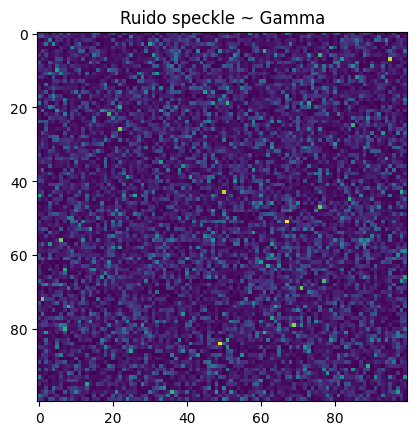

In [62]:
plt.imshow(g)
plt.title('Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Backscatter ~ Gamma inversa')

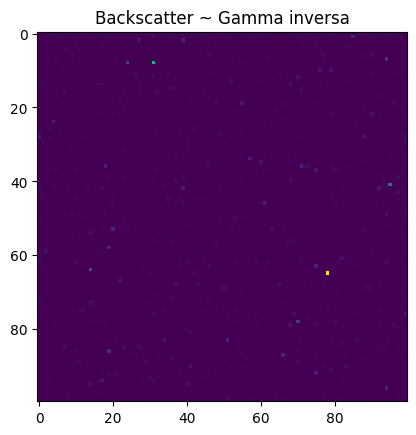

In [63]:
plt.imshow(gi)
plt.title('Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen + ruido speckle ~ GI0')

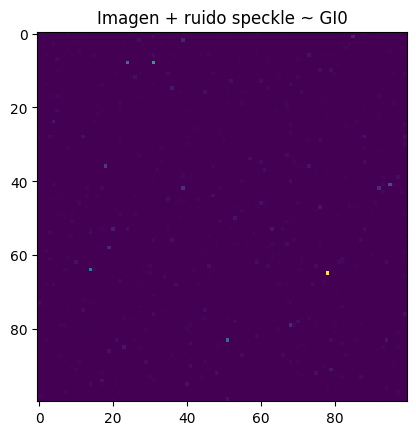

In [64]:
plt.imshow(gI0)
plt.title('Imagen + ruido speckle ~ GI0')

In [65]:
imagen_g, imagen_gi, imagen_gI0 = partitioned_gi0_image(
    p_alphas=[-1.5,-5,-1.7,-10],
    p_gammas=[1,1,1,1],
    p_looks=[1,1,1,1]
)

Text(0.5, 1.0, 'Imagen particionada - Ruido speckle ~ Gamma')

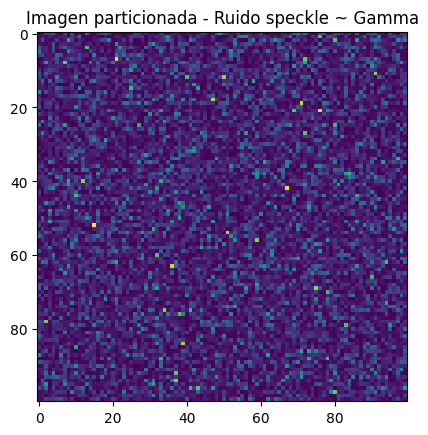

In [66]:
plt.imshow(imagen_g)
plt.title('Imagen particionada - Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Imagen particionada - Backscatter ~ Gamma inversa')

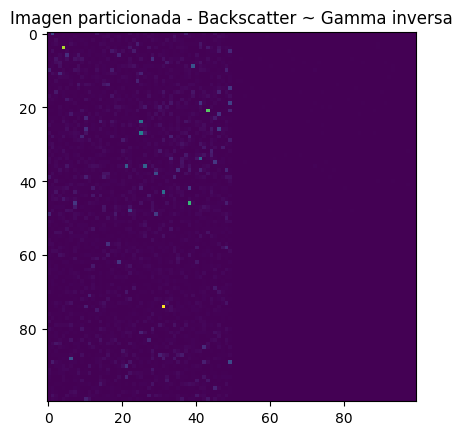

In [67]:
plt.imshow(imagen_gi)
plt.title('Imagen particionada - Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen particionada - Imagen + ruido speckle ~ GI0')

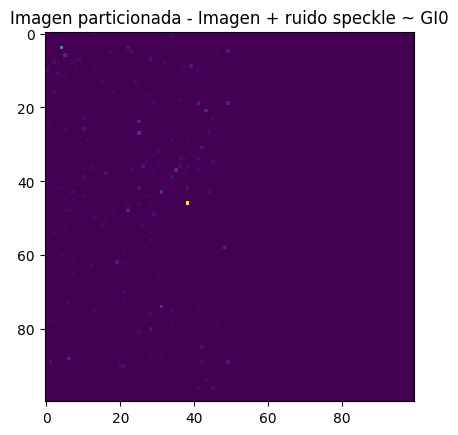

In [68]:
plt.imshow(imagen_gI0)
plt.title('Imagen particionada - Imagen + ruido speckle ~ GI0')

---
### Genero un dataset para entrenar

In [69]:
n = 10000
train_g, train_gi, train_gI0 = generate_multiple_images(n, partitioned_gi0_image)

In [70]:
batch_size = 32

In [71]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [72]:
entrada_red, salida_red = dataset_train[21]

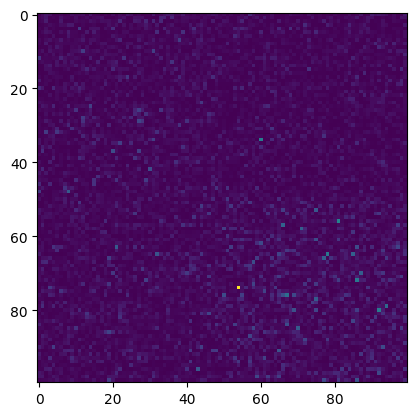

In [73]:
plt.imshow(entrada_red[0,:,:])

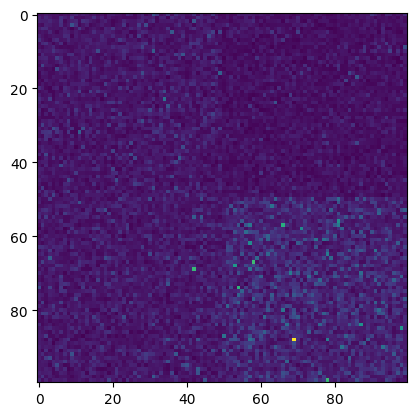

In [74]:
plt.imshow(salida_red[0,:,:])

---
### Entreno

In [75]:
encoding_dim = 32
learning_rate = 1e-3
num_epochs = 40

In [76]:
autoencoder = Autoencoder(encoding_dim)
criterion = nn.BCELoss() # Utilizamos Binary Cross Entropy Loss como loss function ya que las imágenes están normalizadas en el rango [0, 1]
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # El optimizador es responsable de ajustar los pesos del modelo con el fin de minimizar la función de pérdida.
                                                                   # Adam es un algoritmo de optimización popular y eficiente que adapta la tasa de aprendizaje de forma dinámica para cada parámetro del modelo.
                                                                   # La tasa de aprendizaje determina qué tan rápido se ajustan los pesos del modelo durante el entrenamiento.


In [77]:
for epoch in range(num_epochs):
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.view(entrada.size(0), -1).float()
        salida = salida.view(salida.size(0), -1).float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/40], Loss: 0.0684
Epoch [2/40], Loss: 0.1059
Epoch [3/40], Loss: 0.1187
Epoch [4/40], Loss: 0.0545
Epoch [5/40], Loss: 0.0841
Epoch [6/40], Loss: 0.0570
Epoch [7/40], Loss: 0.0508
Epoch [8/40], Loss: 0.0658
Epoch [9/40], Loss: 0.0985
Epoch [10/40], Loss: 0.1136
Epoch [11/40], Loss: 0.1076
Epoch [12/40], Loss: 0.0815
Epoch [13/40], Loss: 0.0489
Epoch [14/40], Loss: 0.1058
Epoch [15/40], Loss: 0.0645
Epoch [16/40], Loss: 0.0491
Epoch [17/40], Loss: 0.1071
Epoch [18/40], Loss: 0.0543
Epoch [19/40], Loss: 0.0950
Epoch [20/40], Loss: 0.1444
Epoch [21/40], Loss: 0.0540
Epoch [22/40], Loss: 0.0537
Epoch [23/40], Loss: 0.0634
Epoch [24/40], Loss: 0.0470
Epoch [25/40], Loss: 0.0792
Epoch [26/40], Loss: 0.0834
Epoch [27/40], Loss: 0.1008
Epoch [28/40], Loss: 0.0518
Epoch [29/40], Loss: 0.0756
Epoch [30/40], Loss: 0.0939
Epoch [31/40], Loss: 0.0911
Epoch [32/40], Loss: 0.0895
Epoch [33/40], Loss: 0.0938
Epoch [34/40], Loss: 0.0693
Epoch [35/40], Loss: 0.1155
Epoch [36/40], Loss: 0.0998
E

---
### Evalúo

In [78]:
# Primero genero el dataset para evaluar

n = 1000
test_g, test_gi, test_gI0 = generate_multiple_images(n, partitioned_gi0_image)

batch_size = 32

dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [79]:
total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        entrada, salida = data # _ se utiliza para descartar las etiquetas, ya que no son necesarias para la evaluación.
        entrada = entrada.view(entrada.size(0), -1).float() # Se modifica la forma de las imágenes para que coincida con el formato esperado por el autoencoder.
                                                         # En este caso, las imágenes se aplanan en un tensor unidimensional. images.size(0) se utiliza para obtener el tamaño del lote.
        salida = salida.view(salida.size(0), -1).float()

        # Forward pass
        outputs = autoencoder(entrada) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                      # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, salida) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")

Average Test Loss: 0.0823


---
### Aplicación del autoencoder a un ejemplo en particular

(-0.5, 99.5, 99.5, -0.5)

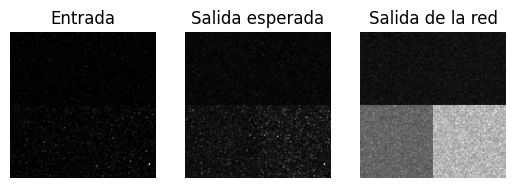

In [81]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida.

index = 78 # Índice del ejemplo puntual que se desea seleccionar
entrada_red, salida_red = dataset_test[index]

example = entrada_red.view(1, -1).float() # Ajusta la forma de la imagen a un lote de tamaño 1

reconstructed = autoencoder(example) # Aplica el autoencoder al ejemplo

entrada = entrada_red.view(100, 100)
salida_esperada = salida_red.view(100, 100)
reconstructed = reconstructed.view(100, 100)

plt.subplot(1, 3, 1)
plt.imshow(entrada, cmap='gray')
plt.title('Entrada')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(salida_esperada, cmap='gray')
plt.title('Salida esperada')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed.detach(), cmap='gray')
plt.title('Salida de la red')
plt.axis('off')